# Ordinary Least Squares in Statsmodels (OLS) - Lab

## Introduction

In the previous code along, we looked all the requirements for running an ols simple regression using statsmodels. We worked with a toy example to understand the process and all the necessary steps that must be performed. In this lab , we shall look at a slightly more complex example to study the impact of spendings in different advertising channels of total sales.

## Objectives

You will be able to:
* Set up an analytical question to be answered by regression analysis
* Study regression assumptions for real world datasets
* Visualize the results of regression analysis

## Let's get started

In this lab, we will work with the "Advertising Dataset" which is a very popular dataset for studying simple regression. [The dataset is available at Kaggle](https://www.kaggle.com/purbar/advertising-data), but we have already downloaded for you. It is available as "Advertising.csv". We shall use this dataset to ask ourselves a simple analytical question:

## The Question

Which advertising channel has a strong relationship with sales volume, and can be used to model and predict the sales. 

### Step 1: Read the dataset and inspect its columns and 5-point statistics

In [64]:
# Load necessary libraries and import the data
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

plt.style.use('ggplot')

df = pd.read_csv('Advertising.csv', index_col=0)

In [65]:
# Check the columns and first few rows
df.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [66]:
# Get the 5-point statistics for data 
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [67]:
# Describe the contents of this dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
TV           200 non-null float64
radio        200 non-null float64
newspaper    200 non-null float64
sales        200 non-null float64
dtypes: float64(4)
memory usage: 7.8 KB


### Step 2: Plot histograms with kde overlay to check for the normality of the predictors

/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


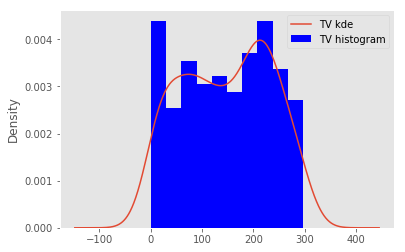

/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


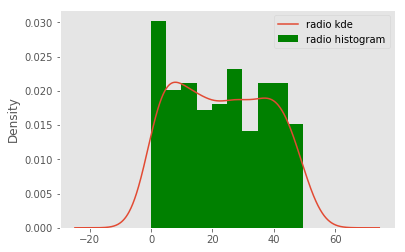

/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


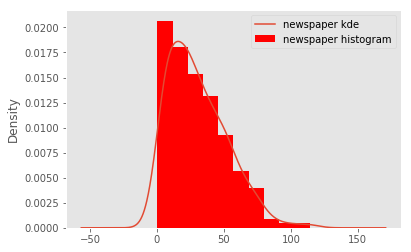

/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


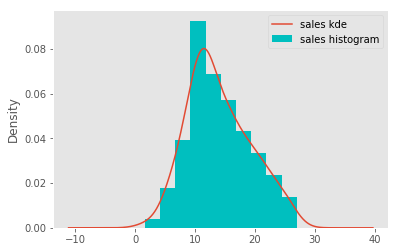

In [68]:
# sn.distplot(df['TV'])
# plt.show()
# sn.distplot(df['radio'])
# plt.show()
# sn.distplot(df['newspaper'])
# plt.show()
# sn.distplot(df['sales'])
# plt.show()

from itertools import cycle
cycol = cycle('bgrcmk')

for column in df:
    df[column].plot.hist(normed=True, label = column+' histogram', color=next(cycol))
    df[column].plot.kde(label= column +' kde')
    plt.grid()
    plt.legend()
    plt.show()

In [69]:
# For all the variables, check if they hold normality assumption


In [70]:
# Record your observations on normality here 
from scipy.stats import kurtosis, skew

for column in df:
    print(f'''{column} has a kurtosis of {round(kurtosis(df[column]), 2)} and a skew of {round(skew(df[column]), 2)}''')
    
# Given none of the distributions have excess kurtosis of 0 or skew of 0, none of them are normally distributed.
# However, of the four columns, sales would be the closest to that of a normal distribution for this entire df.

TV has a kurtosis of -1.23 and a skew of -0.07
radio has a kurtosis of -1.26 and a skew of 0.09
newspaper has a kurtosis of 0.6 and a skew of 0.89
sales has a kurtosis of -0.43 and a skew of 0.4


#### Remember . Nothing is perfect . So be positive 
<img src="https://4.bp.blogspot.com/-e-CL8iluz2o/Vt3Ntg_38kI/AAAAAAAAIJo/zGJMyNaMbFY/s1600/skewed.jpg" width=400>

### Step 3: Test for the linearity assumption. 
Use scatterplots to plot each predictor against the target variable

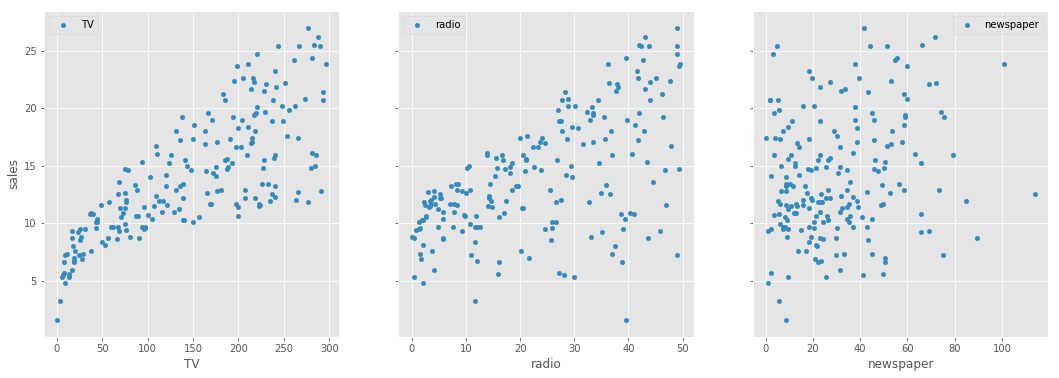

In [71]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
for idx, channel in enumerate(['TV', 'radio', 'newspaper']):
    df.plot(kind='scatter', x=channel, y='sales', ax=axs[idx], label=channel, grid=True, legend=True)
plt.show()

In [72]:
# visualize the relationship between the preditors and the target using scatterplots


In [73]:
# Record yor observations on linearity here 
# TV and radio tend to show a linear relationship between each variable and sales. No such linear relationship
# appears to be found for newspapers

### Conclusion so far !

Based on above initial checks, we can confidently say that TV and radio appear to be good predictors for our regression analysis. Newspaper is very heavily skewed and also doesnt show any clear linear relationship with the target. 
> We shall move ahead with our analysis using TV and radio , and count out the newspaper due to the fact that data violates ols assumptions

Note: Kurtosis can be dealt with using techniques like log normalization to "push" the peak towards the center of distribution. We shall talk about this in the next section. 

### Step 4: Run a simple regression in `statsmodels` with TV as a predictor

In [74]:
from statsmodels.formula.api import ols

f = 'sales~TV'
tv_model = ols(formula=f, data=df).fit()
print(tv_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Sun, 27 Jan 2019   Prob (F-statistic):           1.47e-42
Time:                        18:33:50   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.0

### Step 5: Get regression diagnostics summary


In [76]:
# See above!

### Record your observations on "Goodness of fit"


Note here that the coefficients represent associations, not causations


### Step 6:  Draw a prediction line with data points omn a scatter plot for X (TV) and Y (Sales)

Hint: We can use `model.predict()` functions to predict the start and end point of of regression line for the minimum and maximum values in the 'TV' variable. 

0     7.065869
1    21.122454
dtype: float64


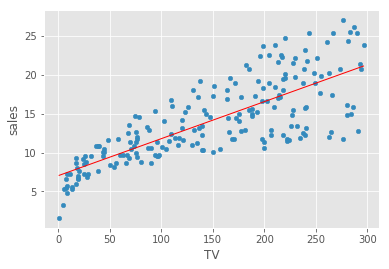

In [77]:
# create a DataFrame with the minimum and maximum values of TV
tv_min_max_df = pd.DataFrame({'TV':[df['TV'].min(), df['TV'].max()]})
tv_predictions = tv_model.predict(tv_min_max_df)
print(tv_predictions)

# make predictions for those x values and store them


# first, plot the observed data and the least squares line

df.plot(kind='scatter', x='TV', y='sales')
plt.plot(tv_min_max_df, tv_predictions, c='red', linewidth=1)
plt.show()

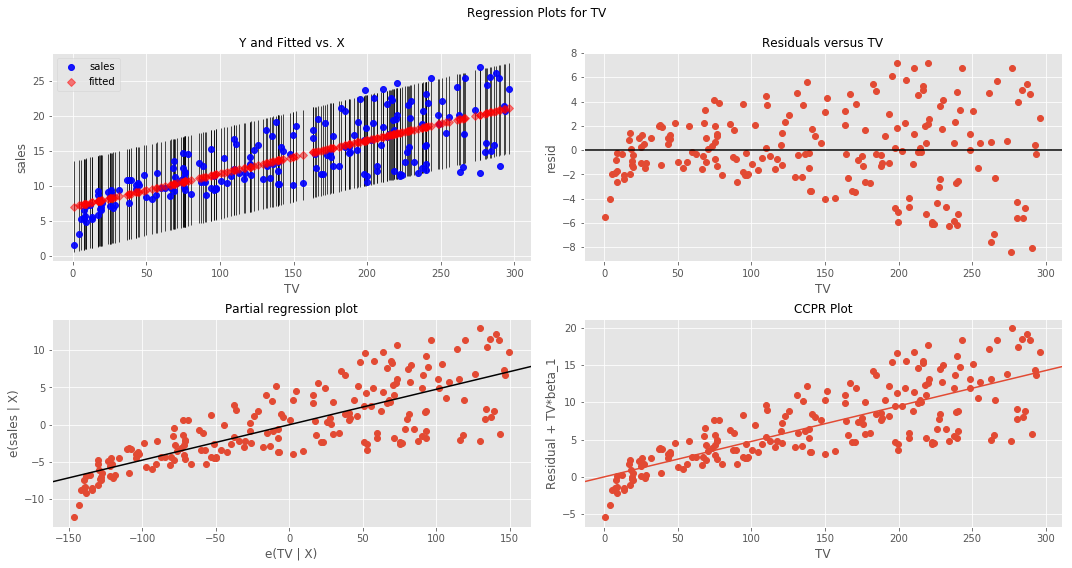

In [78]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(tv_model, "TV", fig=fig)
plt.show()

### Step 7: Visualize the error term for variance and heteroscedasticity

In [79]:
# Record Your observations on residuals

### Next, repeat above for radio and go through the same process, recording your observations

In [80]:
f2 = 'sales~radio'
radio_model = ols(formula=f2, data=df).fit()
print(radio_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     98.42
Date:                Sun, 27 Jan 2019   Prob (F-statistic):           4.35e-19
Time:                        18:34:06   Log-Likelihood:                -573.34
No. Observations:                 200   AIC:                             1151.
Df Residuals:                     198   BIC:                             1157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3116      0.563     16.542      0.0

0     9.311638
1    19.355429
dtype: float64


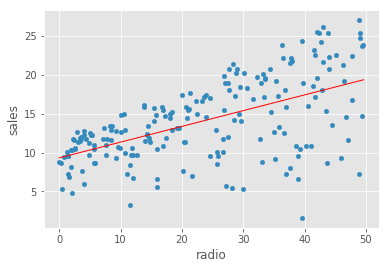

In [81]:
radio_min_max_df = pd.DataFrame({'radio':[df['radio'].min(), df['radio'].max()]})
radio_predictions = radio_model.predict(radio_min_max_df)
print(radio_predictions)

# make predictions for those x values and store them


# first, plot the observed data and the least squares line

df.plot(kind='scatter', x='radio', y='sales')
plt.plot(radio_min_max_df, radio_predictions, c='red', linewidth=1)
plt.show()

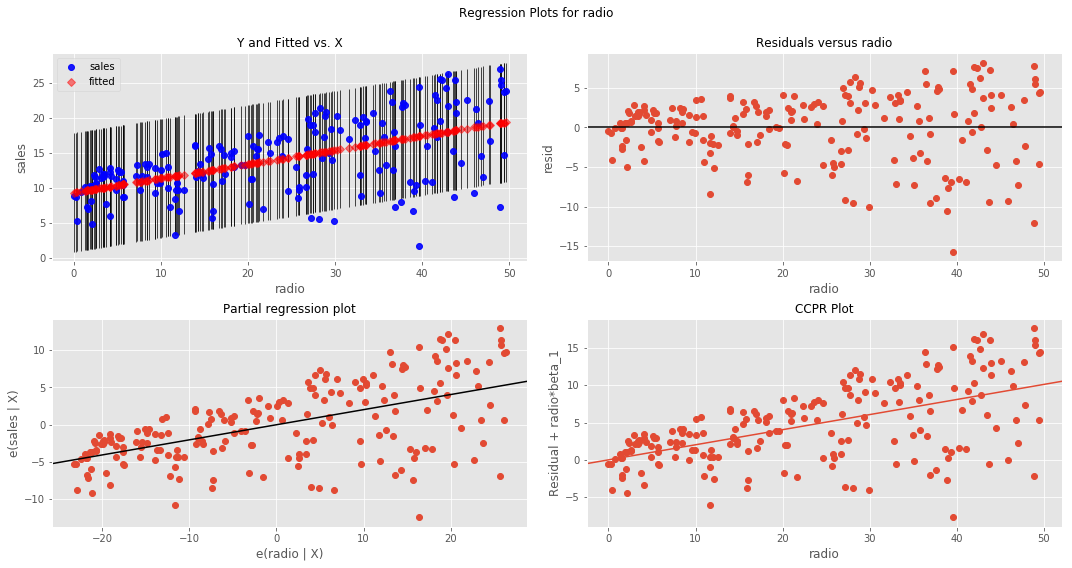

In [82]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(radio_model, "radio", fig=fig)
plt.show()

In [28]:
# Record your observations here for goodnes of fit 

## The Answer


Based on above analysis, we can conclude that none of the two chosen predictors is ideal for modeling a relationship with the sales volumes. `Newspaper` clearly violated normality and linearity assumptions. TV and radio did not provide a high value for co-efficient of determination - TV performed slightly better than the radio. There is obvious heteroscdasticity in the residuals for both variables. 

> We can either look for further data, perform extra pre-processing or use more advanced techniques. 

Remember there are lot of technqiues we can employ to FIX this data. 

Whether we should call TV the "best predictor" or label all of them "equally useless", is a domain specific question and a marketing manager would have a better opinion on how to move forward with this situation. 

In the following lesson, we shall look at the more details on interpreting the regression diagnostics and confidence in the model. 

## Summary

In this lesson, we ran a complete regression analysis with a simple dataset. We looked for the regression assumptions pre and post the analysis phase. We also created some visualizations to develop a confidence on the model and check for its goodness of fit. 

In [ ]:
# Finished January 27, 2019